In [17]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from dbc.utils import compute_conditional_risk

def make_preprocessor(X):
    num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_transformer, num_features),
            ("cat", cat_transformer, cat_features)
        ]
    )
    return preprocessor

def global_risk(y_true, y_pred):
    return np.mean(y_true != y_pred)

def max_gap(y_true, y_pred):
    R = compute_conditional_risk(y_true, y_pred)[0]
    return np.max(R) - np.min(R)

def max_Rk(y_true, y_pred):
    R = compute_conditional_risk(y_true, y_pred)[0]
    return np.max(R)


In [18]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler

# df = fetch_ucirepo(id=17)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=15)  # Breast Cancer Wisconsin
# df = fetch_ucirepo(id=53)  # IRIS
# df = fetch_ucirepo(id=186)  # Wine quality
# df = fetch_ucirepo(id=2)  # Adult
# df = fetch_ucirepo(id=222)  # Bank Marketing
df = fetch_ucirepo(id=19)  # Car Evaluation(表现很差)
# df = fetch_ucirepo(id=73)  # Mushroom
# df = fetch_ucirepo(id=59)  # Letter Recognition(不知道为什么这个数据集DMC和SPDMC效果很差,难道是分类类别过多导致的？)
# df = fetch_ucirepo(id=149)  # Statlog (Vehicle Silhouettes)(如果SPDMC不收敛记得移除类别只有1个的)

# X = df.data.features.replace("?", np.nan)  # Only for adult

X = df.data.features
X = make_preprocessor(X).fit_transform(X)
y = df.data.targets.values.ravel()

# # Onlu for Statlog
# mask = y != '204'
# X = X.iloc[mask] if hasattr(X, 'iloc') else X[mask]
# y = y[mask]

y = LabelEncoder().fit_transform(y)
np.bincount(y)

array([ 384,   69, 1210,   65])

In [19]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
scoring = {
    "global_risk": make_scorer(global_risk, greater_is_better=False),
    "max_Rk": make_scorer(max_Rk, greater_is_better=False),
    "max_gap": make_scorer(max_gap, greater_is_better=False),
}

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

def print_results(results):
    print("Train global_risk: %.3f (± %.3f)" %
          (-results["train_global_risk"].mean(), results["train_global_risk"].std()))
    print("Train max_Rk: %.3f (± %.3f)" %
          (-results["train_max_Rk"].mean(), results["train_max_Rk"].std()))
    print("Train max_gap: %.3f (± %.3f)" %
          (-results["train_max_gap"].mean(), results["train_max_gap"].std()))

    print("Test global_risk: %.3f (± %.3f)" %
          (-results["test_global_risk"].mean(), results["test_global_risk"].std()))
    print("Test max_Rk: %.3f (± %.3f)" %
          (-results["test_max_Rk"].mean(), results["test_max_Rk"].std()))
    print("Test max_gap: %.3f (± %.3f)" %
          (-results["test_max_gap"].mean(), results["test_max_gap"].std()))

In [33]:
from sklearn.model_selection import cross_validate
from dbc.main import KmeansDiscreteMinimaxClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

T = 5
model = KmeansDiscreteMinimaxClassifier(n_clusters=T)
results_DMC = cross_validate(
    model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True
)
print('DMC results:')
print_results(results_DMC)
# DMC results:
# Train global_risk: 0.599 (± 0.006)
# Train max_Rk: 0.629 (± 0.017)
# Train max_gap: 0.055 (± 0.034)
# Test global_risk: 0.609 (± 0.008)
# Test max_Rk: 0.646 (± 0.017)
# Test max_gap: 0.066 (± 0.032)

DMC results:
Train global_risk: 0.655 (± 0.140)
Train max_Rk: 0.847 (± 0.151)
Train max_gap: 0.437 (± 0.193)
Test global_risk: 0.669 (± 0.143)
Test max_Rk: 0.877 (± 0.138)
Test max_gap: 0.455 (± 0.186)


In [34]:
from dbc.main import CmeansDiscreteMinmaxClassifier
# T = 7
fuzzifier = 1.3
model = CmeansDiscreteMinmaxClassifier(n_clusters=T, fuzzifier=fuzzifier, use_kmeans=True)
results_SPDMC = cross_validate(
    model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True
)
print('SPDMC results:')
print_results(results_SPDMC)

SPDMC results:
Train global_risk: 0.573 (± 0.052)
Train max_Rk: 0.599 (± 0.063)
Train max_gap: 0.057 (± 0.083)
Test global_risk: 0.583 (± 0.064)
Test max_Rk: 0.759 (± 0.127)
Test max_gap: 0.313 (± 0.167)


In [35]:
model = LogisticRegression(class_weight='balanced',max_iter=1000)
results_WLR = cross_validate(
    model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True
)
print('WLR results:')
print_results(results_WLR)

WLR results:
Train global_risk: 0.105 (± 0.003)
Train max_Rk: 0.114 (± 0.004)
Train max_gap: 0.114 (± 0.004)
Test global_risk: 0.112 (± 0.025)
Test max_Rk: 0.162 (± 0.068)
Test max_gap: 0.162 (± 0.068)


In [36]:
model = DecisionTreeClassifier(class_weight='balanced',max_depth=5)
results_WDT = cross_validate(
    model,
    X, y,
    cv=rskf,
    scoring=scoring,
    return_train_score=True
)
print('WDT results:')
print_results(results_WDT)

WDT results:
Train global_risk: 0.258 (± 0.008)
Train max_Rk: 0.471 (± 0.039)
Train max_gap: 0.471 (± 0.039)
Test global_risk: 0.268 (± 0.032)
Test max_Rk: 0.511 (± 0.069)
Test max_gap: 0.511 (± 0.069)


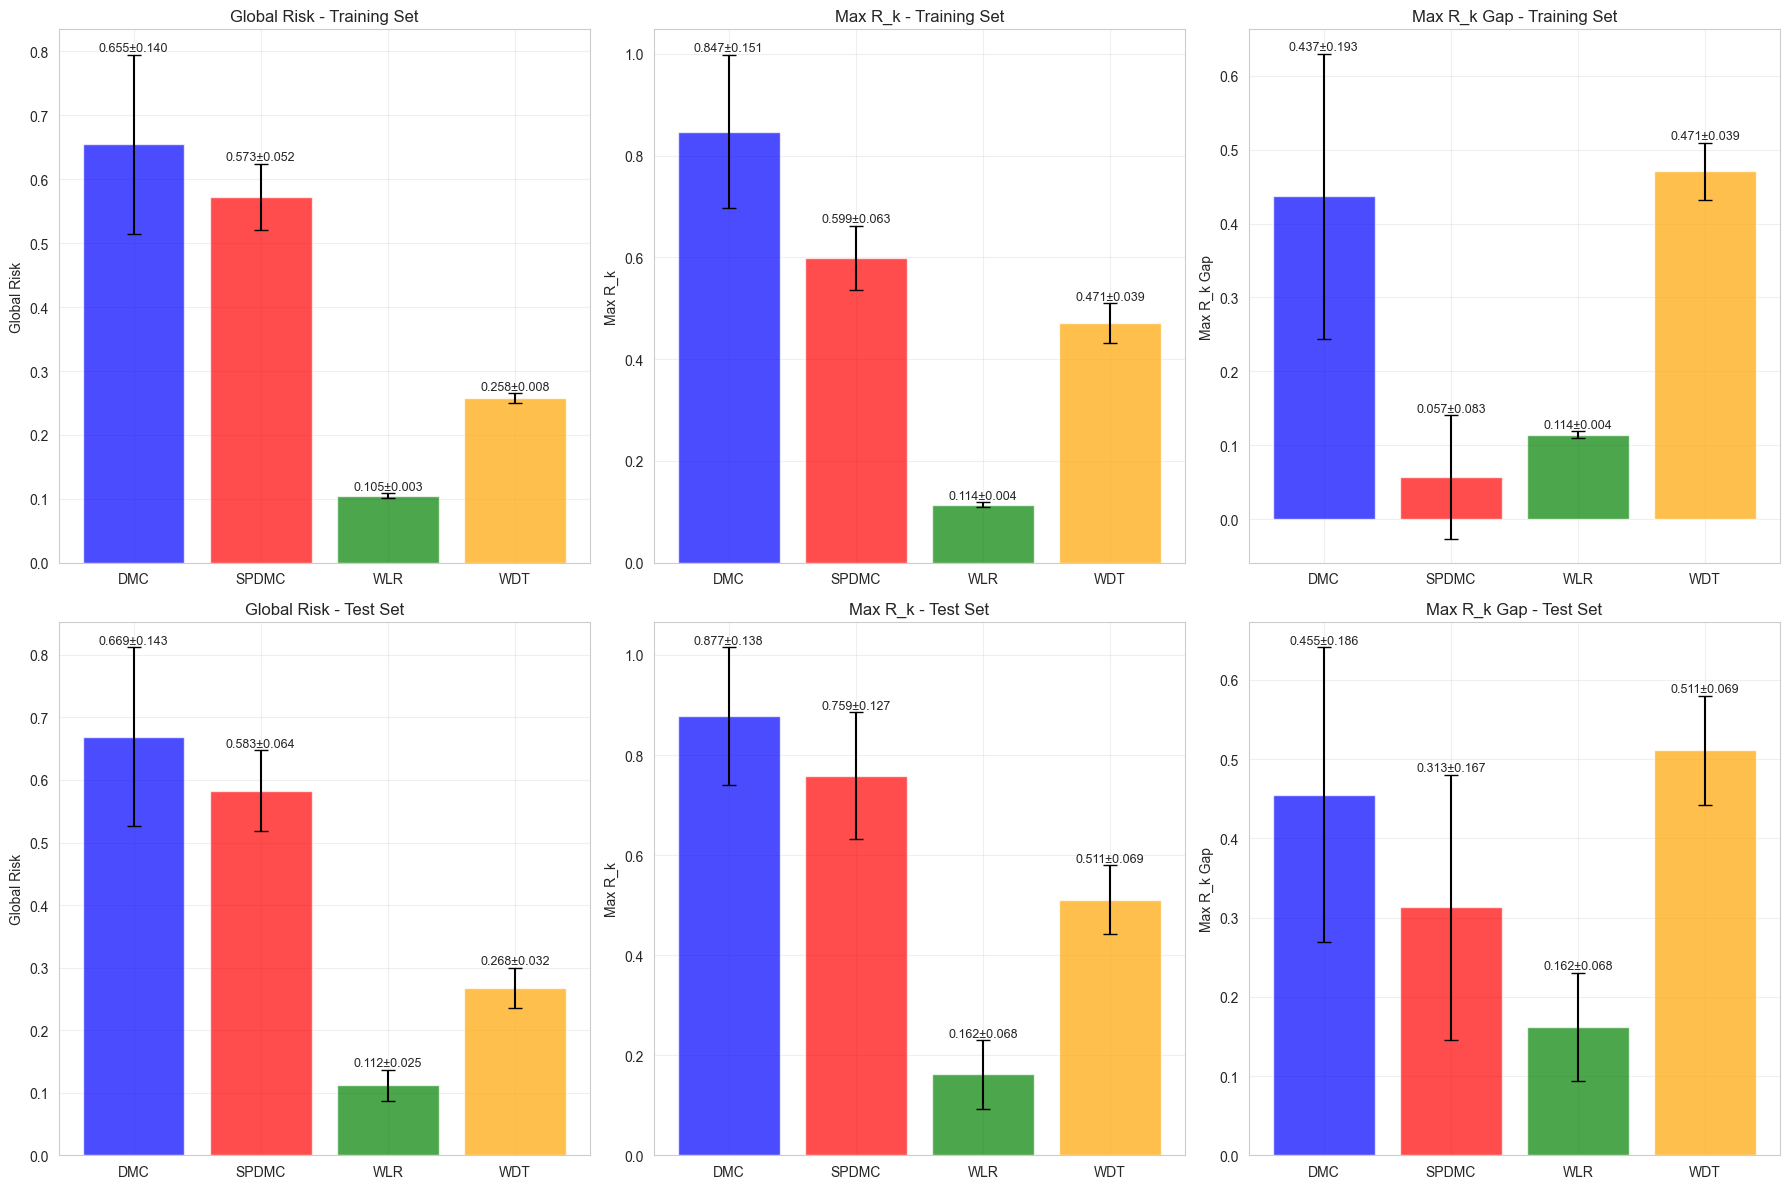

In [37]:

import matplotlib.pyplot as plt
import numpy as np

# 收集所有结果
results_dict = {
    'DMC': results_DMC,
    'SPDMC': results_SPDMC,
    'WLR': results_WLR,
    'WDT': results_WDT
}

# 定义指标和标签
metrics = ['global_risk', 'max_Rk', 'max_gap']
metric_labels = ['Global Risk', 'Max R_k', 'Max R_k Gap']

# 创建子图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 为每个指标创建训练集和测试集的对比图
for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    # 训练集结果
    ax_train = axes[i]
    train_means = [-results_dict[model][f'train_{metric}'].mean() for model in results_dict.keys()]
    train_stds = [results_dict[model][f'train_{metric}'].std() for model in results_dict.keys()]

    bars = ax_train.bar(results_dict.keys(), train_means, yerr=train_stds,
                        capsize=5, alpha=0.7, color=['blue', 'red', 'green', 'orange'])
    ax_train.set_title(f'{label} - Training Set')
    ax_train.set_ylabel(label)
    ax_train.grid(True, alpha=0.3)

    # 添加数值标签
    for bar, mean, std in zip(bars, train_means, train_stds):
        height = bar.get_height()
        ax_train.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                     f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

    # 测试集结果
    ax_test = axes[i + 3]
    test_means = [-results_dict[model][f'test_{metric}'].mean() for model in results_dict.keys()]
    test_stds = [results_dict[model][f'test_{metric}'].std() for model in results_dict.keys()]

    bars = ax_test.bar(results_dict.keys(), test_means, yerr=test_stds,
                       capsize=5, alpha=0.7, color=['blue', 'red', 'green', 'orange'])
    ax_test.set_title(f'{label} - Test Set')
    ax_test.set_ylabel(label)
    ax_test.grid(True, alpha=0.3)

    # 添加数值标签
    for bar, mean, std in zip(bars, test_means, test_stds):
        height = bar.get_height()
        ax_test.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                     f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [5]:
# 该单元格为运行一次实验所需
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from dbc.main import KmeansDiscreteMinimaxClassifier, CmeansDiscreteMinmaxClassifier
from dbc import compute_conditional_risk

T = 40
fuzzifier = 1.3

# ---------------------------------------------------------------------------
DMC = KmeansDiscreteMinimaxClassifier(n_clusters=T)
DMC.fit(X_train, y_train)

y_pred_DMC_test = DMC.predict(X_test)
risks_DMC_test = compute_conditional_risk(y_test, y_pred_DMC_test)[0]
y_pred_DMC_train = DMC.predict(X_train)
risks_DMC_train = compute_conditional_risk(y_train, y_pred_DMC_train)[0]

print("DMC train empirical class conditional risk:\n", risks_DMC_train, "\n")
print("DMC test empirical class conditional risk:\n", risks_DMC_test, "\n")

# ---------------------------------------------------------------------------
from dbc import CmeansDiscreteBayesianClassifier
from dbc.utils import compute_SPDBC_pi_star

SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteBayesianClassifier(n_clusters=T, fuzzifier=fuzzifier, cluster_centers=DMC.cluster_centers)
# SPDBC = CmeansDiscreteMinmaxClassifier(n_clusters=T, fuzzifier=fuzzifier, use_kmeans=True)
SPDBC.fit(X_train, y_train)

pi_star_SPDBC, risk_history = compute_SPDBC_pi_star(X_train, y_train, SPDBC.loss_function, SPDBC.p_hat,
                                                    SPDBC.membership_degree, SPDBC.prior, alpha=1, beta=0.8,n_iter=300, eps=1e-3,
                                                    return_history=True)
# print(pi_star_SPDBC)
y_pred_SPDBC_train = SPDBC.predict(X_train, prior_pred=pi_star_SPDBC)
y_pred_SPDBC_test = SPDBC.predict(X_test, prior_pred=pi_star_SPDBC)
# y_pred_SPDBC_train = SPDBC.predict(X_train)
# y_pred_SPDBC_test = SPDBC.predict(X_test)
risks_SPDBC_test = compute_conditional_risk(y_test, y_pred_SPDBC_test)[0]


risks_SPDBC_train = compute_conditional_risk(y_train, y_pred_SPDBC_train)[0]

print("SPDEC train empirical class conditional risk:\n", risks_SPDBC_train, "\n")
print("SPDEC test empirical class conditional risk:\n", risks_SPDBC_test, "\n")

# ---------------------------------------------------------------------------
from sklearn.linear_model import LogisticRegression

# 代价敏感 Logistic Regression
LR = LogisticRegression(class_weight='balanced')
LR.fit(X_train, y_train)

y_pred_LR_train = LR.predict(X_train)
risks_LR_train = compute_conditional_risk(y_train, y_pred_LR_train)[0]

y_pred_LR_test = LR.predict(X_test)
risks_LR_test = compute_conditional_risk(y_test, y_pred_LR_test)[0]

print("LR train empirical class conditional risk:\n", risks_LR_train, "\n")
print("LR test empirical class conditional risk:\n", risks_LR_test, "\n")

# SVM在高纬度下运行太慢了，adult跑一次十分钟跑不完，干脆注释掉了
# ---------------------------------------------------------------------------
# from sklearn.svm import SVC
#
# # 代价敏感 SVM
# SVM = SVC(class_weight='balanced', probability=True, kernel='linear')  # 添加probability=True以便获得概率预测
# SVM.fit(X_train, y_train)
#
# y_pred_SVM_train = SVM.predict(X_train)
# risks_SVM_train = compute_conditional_risk(y_train, y_pred_SVM_train)[0]
#
# y_pred_SVM_test = SVM.predict(X_test)
# risks_SVM_test = compute_conditional_risk(y_test, y_pred_SVM_test)[0]
#
# print("SVM train empirical class conditional risk:\n", risks_SVM_train, "\n")
# print("SVM test empirical class conditional risk:\n", risks_SVM_test, "\n")


# ---------------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier

# 代价敏感决策树
DT = DecisionTreeClassifier(class_weight='balanced', random_state=42)
DT.fit(X_train, y_train)

y_pred_DT_train = DT.predict(X_train)
risks_DT_train = compute_conditional_risk(y_train, y_pred_DT_train)[0]

y_pred_DT_test = DT.predict(X_test)
risks_DT_test = compute_conditional_risk(y_test, y_pred_DT_test)[0]

print("Decision Tree train empirical class conditional risk:\n", risks_DT_train, "\n")
print("Decision Tree test empirical class conditional risk:\n", risks_DT_test, "\n")

DMC train empirical class conditional risk:
 [0.70833333 0.60693642 0.62105263 0.62758925 0.63035921 0.62987013
 0.75      ] 

DMC test empirical class conditional risk:
 [0.66666667 0.48837209 0.68457944 0.67195767 0.6712963  0.76923077
 1.        ] 

SPDEC train empirical class conditional risk:
 [0.58333333 0.60693642 0.60701754 0.607316   0.60602549 0.6038961
 0.5       ] 

SPDEC test empirical class conditional risk:
 [0.5        0.58139535 0.6588785  0.61904762 0.62962963 0.76923077
 0.        ] 

LR train empirical class conditional risk:
 [0.5        0.51445087 0.62105263 0.75760247 0.70336037 0.46103896
 0.        ] 

LR test empirical class conditional risk:
 [0.5        0.51162791 0.66588785 0.74603175 0.72685185 0.53846154
 1.        ] 

Decision Tree train empirical class conditional risk:
 [0. 0. 0. 0. 0. 0. 0.] 

Decision Tree test empirical class conditional risk:
 [1.         0.81395349 0.34813084 0.39858907 0.41203704 0.56410256
 1.        ] 



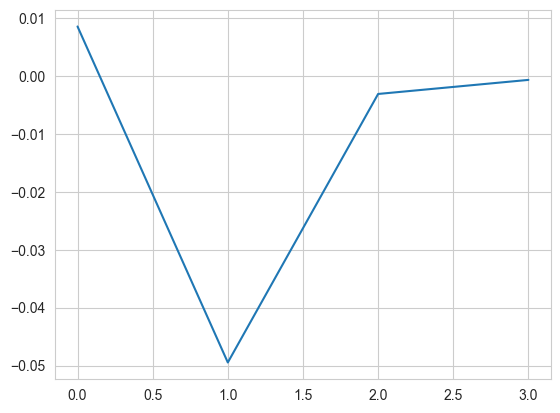

In [10]:
from matplotlib import pyplot as plt

plt.plot(risk_history)
# plt.ylim(-0.01, 0.01)